## Бутстрап
Бутстрап позволяет многократно извлекать подвыборки из выборки, полученной в рамках экспериментва

В полученных подвыборках считаются статистики (среднее, медиана и т.п.)

Из статистик можно получить ее распределение и взять доверительный интервал

ЦПТ, например, не позволяет строить доверительные интервал для медианы, а бутстрэп это может сделать

In [12]:
import numpy as np
import pandas as pd
from scipy.stats import norm, mannwhitneyu
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

plt.style.use('ggplot')

In [9]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_0: list, # числовые значения первой выборки
    data_1: list, # числовые значения второй выборки
    boot_it: int = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    conf_level: float = 0.95, # уровень значимости,
    ba: bool = False
):
    boot_data = []
    for _ in tqdm(range(boot_it)): # извлекаем подвыборки
        boot_0 = data_0.sample(len(data_0), replace = True).values
        boot_1 = data_1.sample(len(data_1), replace = True).values
        boot_data.append(statistic(boot_0) - statistic(boot_1)) # mean() - применяем статистику
        
    # поправляем смещение
    if ba:
        orig_theta = statistic(data_0)-statistic(data_1) # разница в исходных данных
        boot_theta = np.mean(boot_data) # среднее по бутстрапированной разнице статистик
        delta_val = abs(orig_theta - boot_theta) # дельта для сдвига
        boot_data = [i - delta_val for i in boot_data] # сдвигаем бут разницу статистик, обратите внимание, что тут не вычитание
        print(f"""
            До бутстрапа: {orig_theta},
            После бутстрапа: {boot_theta},
            После коррекции: {np.mean(boot_data)}"""
        )

    left_quant = (1 - conf_level)/2
    right_quant = 1 - (1 - conf_level) / 2
    ci = pd.DataFrame(boot_data).quantile([left_quant, right_quant])

    # p-value
    p_1 = norm.cdf(x = 0, loc = np.mean(boot_data), scale = np.std(boot_data))
    p_2 = norm.cdf(x = 0, loc = -np.mean(boot_data), scale = np.std(boot_data))
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd.DataFrame(boot_data)[0], bins = 50)
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

In [10]:
# будем пробовать бутстрап на эксп. распределении
np.random.seed(5)

n = 1000
lift = 1.01

x = np.random.exponential(size=n)
y = np.random.exponential(size=n) * lift

df = pd.DataFrame({"x": x, "y": y})

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 3209.12it/s]



            До бутстрапа: -0.06171236871031671,
            После бутстрапа: -0.05975448556642615,
            После коррекции: -0.0577966024225356
0.9314594092800013 0.06854059071999873


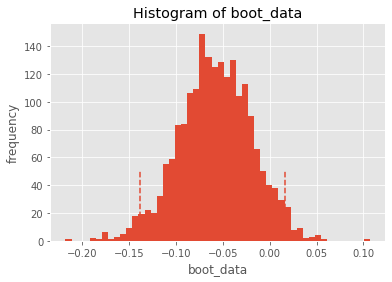

In [11]:
booted_data = get_bootstrap(df.x, df.y, statistic=lambda x: np.quantile(x, q=.5), ba = True, boot_it = 2000) # в результате хранится разница двух распределений, ДИ и pvalue

In [7]:
booted_data["p_value"]

0.13708118143999745

In [8]:
booted_data["ci"]

,0
0.025,-0.138476
0.975,0.016503
